# Finding hidden data

**Milestone 2 of final project (Applied Data Analysis)**

**Team: Salmon Tortilla al Pesto**

**TODO: EXPLAIN NEW THINGS THAT WE WILL DO IN THIS PART, AND ALSO QUESTIONS ANSWERED IN THE NOTEBOOK, ADD NEW QUESTIONS IN GENERAL**

This jupyter notebook correspond to one part (out of two) of the total report for this milestone. In this notebook we work on the [recpies dataset](http://pic2recipe.csail.mit.edu). Here we will import the dataset, analyize it, search for missing data, clean it, filter it, and start the analysis to ensure that everything is ok for the final milestone. Before starting with all the mentioned tasks, we will present the idea and objectives of this part of the project.

Nowadays, huge advances in medicine and nutrition have led us to understand that the way we eat plays the most important role in our health. Following a diet rich in omega 6, for example, will lead us into different diseases, like cancer. Avoiding bad diets is “easily” achieved by eating a great variety of different food, at the same time as minimizing the amount of unhealthy meals. However, things can get harder when we have certain restrictions or obligations in our diet, for instance, we have to counter a lack of iron or if we are vegan.

In this part of the project, we will use the `Recipe1M+` dataset to find the correlation between ingredients and see which ingredients are more likely to appear together in a recipe. This way, we will investigate how some restriction or obligations in our diets can affect undesired raises in specific aliments. 

This are some of the questions we want to answer in this project:

- What is the presence correlation between ingredients in recipes?
- Are there increases/decreases in the consumption of some ingredients when fighting against a specific disease via nutrition?
- Are there increases/decreases in the consumption of some ingredients when having restrictions in our diet?
- Which recipes are recommended to fight against a specific disease while not resulting in an undesirable increase of some other ingredients?
- Is it easier or harder for people con restriction in their diets to eat "healthy"?
- Which type of meals (e.g. spicy) are more correlated with unhealthy food?
- More...

In this first approach, we will base our project in 5 specific nutrition situations, expanding it for the third milestone:

- Lactose intolerance
- Gluten intolerance
- Vegetarian diet
- Countering lack of iron
- Countering lack of omega 3


## Table of contents

**1. Analysis and cleaning of the datasets:** In this part we import the data, look for missing or/and NaN values, clean the data, format it if needed and filter it.

**2. General analysis of the data:** Before going into the analysis we intent to do, we first do a more general analysis of the ingredients in recepies to obtain important information we will need for extracting the proper conclusions. In addition, in this part we will solve unexpected errors encountered.

**3. Starting the core analysis:** In this part we will really start with the core project in order to see that everything is ok for the final report.

**4. Conclusions:** Important conclusions of the work done in this milestone.

In [1]:
# Importing libraries
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
import time
import operator

In [2]:
# For beauty printing
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [3]:
# Main printing function
def printMain(to_print):
    print(color.BLUE + color.BOLD + to_print + color.END)

## 1) Analysis and cleaning of the datasets

In this first section we get the datasets into pandas and analyise the structure and the content of them. The we find and handle NaN and missing values, clean and format the data, and filter it to remove unnecesary features or items. Finally we adapt the data for the following analysis.

We have two datasets: `layer1.json` that has information about list of recepies, and `det_ingrs.json` with the ingredients of the recepies from the previous dataset in a cleaner way.

### Importing the data
First of all, lets import both datasets and analyse them.

In [4]:
# Importing layer1.json
initial_time = time.time()
df_recepies = pd.read_json('data/layer1.json')
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("layer1.json dataset:")
df_recepies.head()

(Time: 39.36 seconds)
layer1.json dataset:


,ingredients,url,partition,title,id,instructions
0,"[{'text': '6 ounces penne'}, {'text': '2 cups ...",http://www.epicurious.com/recipes/food/views/-...,train,Worlds Best Mac and Cheese,000018c8a5,[{'text': 'Preheat the oven to 350 F. Butter o...
1,"[{'text': '1 c. elbow macaroni'}, {'text': '1 ...",http://cookeatshare.com/recipes/dilly-macaroni...,train,Dilly Macaroni Salad Recipe,000033e39b,[{'text': 'Cook macaroni according to package ...
2,"[{'text': '8 tomatoes, quartered'}, {'text': '...",http://www.foodnetwork.com/recipes/gazpacho1.html,train,Gazpacho,000035f7ed,[{'text': 'Add the tomatoes to a food processo...
3,"[{'text': '2 12 cups milk'}, {'text': '1 12 cu...",http://www.food.com/recipe/crunchy-onion-potat...,test,Crunchy Onion Potato Bake,00003a70b1,[{'text': 'Preheat oven to 350 degrees Fahrenh...
4,[{'text': '1 (3 ounce) package watermelon gela...,http://www.food.com/recipe/cool-n-easy-creamy-...,train,Cool 'n Easy Creamy Watermelon Pie,00004320bb,"[{'text': 'Dissolve Jello in boiling water.'},..."


In [5]:
# Importing det_ingrs.json
initial_time = time.time()
df_ingredients = pd.read_json('data/det_ingrs.json')
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("det_ingrs.json dataset:")
df_ingredients.head()

(Time: 19.01 seconds)
det_ingrs.json dataset:


,valid,id,ingredients
0,"[True, True, True, True, True, True, True, Tru...",000018c8a5,"[{'text': 'penne'}, {'text': 'cheese sauce'}, ..."
1,"[True, True, True, True, True, True, True, Tru...",000033e39b,"[{'text': 'elbow macaroni'}, {'text': 'America..."
2,"[True, True, True, True, True, True, True, Tru...",000035f7ed,"[{'text': 'tomatoes'}, {'text': 'kosher salt'}..."
3,"[True, True, True, True, True, True, True]",00003a70b1,"[{'text': 'milk'}, {'text': 'water'}, {'text':..."
4,"[True, True, True, True, True]",00004320bb,"[{'text': 'watermelon gelatin'}, {'text': 'boi..."


We can see that the first dataset has no information interesting for our analysis so far. The title, url and insturctions are not useful for us, and the ingridients will be taken from the `df_ingredients` as they are more clean, and so, easier to use. We delete the first dataFrame.

In [6]:
# Deleting the first dataset
del df_recepies 

### Removing unnecessary data

In the `df_ingredients` we have 3 columns. The `ingredients` column is the most important one. `id` columns will be kept in the dataset, just in case we need to relate the two datasets in the future. The `valid` column will be deleted as it is not needed. Let's delete that feature.

In [7]:
df_ingredients = df_ingredients.drop(columns=['valid'])
df_ingredients.head()

,id,ingredients
0,000018c8a5,"[{'text': 'penne'}, {'text': 'cheese sauce'}, ..."
1,000033e39b,"[{'text': 'elbow macaroni'}, {'text': 'America..."
2,000035f7ed,"[{'text': 'tomatoes'}, {'text': 'kosher salt'}..."
3,00003a70b1,"[{'text': 'milk'}, {'text': 'water'}, {'text':..."
4,00004320bb,"[{'text': 'watermelon gelatin'}, {'text': 'boi..."


### Dealing with missing data

Before moving on, let's look if the dataframe has NaN data or empty list of ingredients:

In [8]:
# Looking for NaN values
printMain("Are there any null values?")
df_ingredients.isnull().values.any()

Are there any null values?


False

In [9]:
# Looking for empty lists
df_empty_rows = df_ingredients[df_ingredients['ingredients'].map(lambda d: len(d)) == 0]
printMain("What is the number of empty ingredient lists?")
len(df_empty_rows)

What is the number of empty ingredient lists?


0

We can see that there are no missing or empty values. Nothing to clean or fill.

It is true that there can still be missing ingredients, but if this is true, we will find an ingredient named "". We now this does not happend, this can be seen ahead in the notebook.

### Reformating data

We can also see that the `ingredients` column is not good formated. It would be more useful to have only a list of the ingredient of each recepie. Also, we ensure that ingredients are lower case, to abvoid having same ingredients in different recepies that are different string. We will also remove repeated ingredients in the list (*This was detected in the second section, but it is done here for cleaness*)

In this process of reformating the data, we do another thing. We found out in the general analysis that some ingredients sometimes are written in plural or singular. Also, some ingredients are separated into groups with too much granularity, which is not good for us. For example, 'chicken breasts' or 'chicken' for our analysis is the same, just chicken. In the following cell, we present a dictionary which keys are ingredients that need to be transoformed ('chicken breasts'), and the values are the string into which the ingredients need to be transformed ('chicken').

*The generation of the dictionary was purly manual. Geting the most common ingredients (~500) and selecting the changes useful for our purpose.*

In [10]:
# Dictionary of format changes
dic_ingredients_changes = {
    "all - purpose flour": "flour",
    "whole wheat flour": "flour",
    "bread flour": "flour",
    "plain flour": "flour",
    "cake flour": "flour",
    "brown sugar": "sugar",
    "granulated sugar": "sugar",
    "white sugar": "sugar",
    "powdered sugar": "sugar",
    "confectioners' sugar": "sugar",
    "light brown sugar": "sugar",
    "dark brown sugar": "sugar",
    "caster sugar": "sugar",
    "extra virgin olive oil": "olive oil",
    "canola oil": "vegetable oil",
    "sesame oil": "vegetable oil",
    "peanut oil": "vegetable oil",
    "kosher salt": "salt",
    "sea salt": "salt",
    "seasoning salt": "salt",
    "coarse salt": "salt",
    "fresh parsley": "parsley",
    "flat leaf parsley": "parsley",
    "fresh parsley leaves": "parsley",
    "onions": "onion",
    "red onion": "onion",
    "red onions": "onion",
    "onion powder": "onion",
    "yellow onion": "onion",
    "yellow onions": "onion",
    "black pepper": "pepper",
    "fresh ground black pepper": "pepper",
    "ground black pepper": "pepper",
    "white pepper": "pepper",
    "crushed red pepper flakes": "red pepper flakes",
    "red bell pepper": "bell pepper",
    "red bell peppers": "bell pepper",
    "green peppers": "bell pepper",
    "green bell pepper": "bell pepper",
    "green bell peppers": "bell pepper",
    "green pepper": "bell pepper",
    "red peppers": "bell pepper",
    "bell peppers": "bell pepper",
    "red pepper": "bell pepper",
    "lemon juice": "lemon",
    "fresh lemon juice": "lemon",
    "lemons": "lemon",
    "lemon zest": "lemon",
    "fresh cilantro": "cilantro",
    "fresh ginger": "ginger",
    "ground ginger": "ginger",
    "boneless skinless chicken breasts": "chicken",
    "chicken breasts": "chicken",
    "cooked chicken": "chicken",
    "boneless skinless chicken breast halves": "chicken",
    "chicken stock": "chicken broth",
    "fresh basil": "basil",
    "dried basil": "basil",
    "fresh basil leaves": "basil",
    "basil leaves": "basil",
    "ground cumin": "cumin",
    "cumin seeds": "cumin",
    "bay leaves": "bay leaf",
    "dried thyme": "thyme",
    "fresh thyme": "thyme",
    "diced tomatoes": "tomatoes",
    "cherry tomatoes": "tomatoes",
    "plum tomatoes": "tomatoes",
    "dijon mustard": "mustard",
    "dry mustard": "mustard",
    "boiling water": "water",
    "cold water": "water",
    "warm water": "water",
    "hot water": "water",
    "ice": "water",
    "ice cubes": "water",
    "parmesan cheese": "cheese",
    "cheddar cheese": "cheese",
    "mozzarella cheese": "cheese",
    "shredded cheddar cheese": "cheese",
    "feta cheese": "cheese",
    "sharp cheddar cheese": "cheese",
    "monterey jack cheese": "cheese",
    "swiss cheese": "cheese",
    "ricotta cheese": "cheese",
    "blue cheese": "cheese",
    "parmigiano - reggiano cheese": "cheese",
    "celery ribs": "celery",
    "balsamic vinegar": "vinegar",
    "red wine vinegar": "vinegar",
    "cider vinegar": "vinegar",
    "white vinegar": "vinegar",
    "white wine vinegar": "vinegar",
    "apple cider vinegar": "vinegar",
    "rice vinegar": "vinegar",
    "heavy cream": "cream",
    "whipping cream": "cream",
    "heavy whipping cream": "cream",
    "whipped cream": "cream",
    "vanilla extract": "vanilla",
    "pure vanilla extract": "vanilla",
    "vanilla ice cream": "vanilla",
    "fresh mushrooms": "mushrooms",
    "sliced mushrooms": "mushrooms",
    "cream of mushroom soup": "mushrooms",
    "maple syrup": "syrup",
    "light corn syrup": "syrup",
    "shallots": "shallot",
    "fresh chives": "chives",
    "banana": "bananas",
    "lime juice": "lime",
    "fresh lime juice": "lime",
    "limes": "lime",
    "orange juice": "orange",
    "orange zest": "orange",
    "oranges": "orange",
    "of fresh mint": "mint",
    "semi - sweet chocolate chips": "chocolate",
    "chocolate chips": "chocolate",
    "semisweet chocolate": "chocolate",
    "ground allspice": "allspice",
    "cooked rice": "rice",
    "granny smith apples": "apple",
    "apples": "apple",
    "sliced almonds": "almonds",
    "slivered almonds": "almonds",
    "spaghetti": "pasta",
    "unsalted butter": "butter",
    "garlic cloves": "garlic",
    "garlic clove": "garlic",
    "garlic powder": "garlic",
    "garlic salt": "garlic",
    "panko breadcrumbs": "breadcrumbs",
    "white bread": "bread",
    "french bread": "bread",
    "black olives": "olives",
    "kalamata olives": "olives",
    "active dry yeast": "yeast",
    "fresh spinach": "spinach",
    "cracked black pepper": "pepper",
    "cream of chicken soup": "chicken broth",
    "cooking oil": "oil",
    "dry white wine": "white wine",
    "dry sherry": "red wine",
    "crushed tomatoes": "tomatoes",
    "goat cheese": "cheese",
    "fresh strawberries": "strawberries",
    "broccoli florets": "broccoli",
    "celery seeds": "celery",
    "bittersweet chocolate": "chocolate",
    "icing sugar": "sugar",
    "red potatoes": "potatoes",
    "russet potatoes": "potatoes",
    "salmon fillets": "salmon",
    "hot pepper sauce": "hot sauce",
    "dried parsley": "parsley",
    "pineapple juice": "pineapple",
    "crushed pineapple": "pineapple",
    "jalapeno peppers": "jalapeno",
    "jalapenos": "jalapeno",
    "low sodium chicken broth": "chicken",
    "chili powder": "chili",
    "green chilies": "chili",
    "whole milk": "milk",
    "low - fat milk": "milk",
    "skim milk": "milk",
    "avocados": "avocado",
    "rolled oats": "oat",
    "unsweetened cocoa powder": "cocoa",
    "cayenne pepper": "cayenne",
    "lean ground beef": "beef",
    "cucumbers": "cucumber",
    "rosemary": "fresh rosemary",
    "ground nutmeg": "nutmeg",
    "fresh ground pepper": "pepper",
    "tomato paste": "tomatoes",
    "eggs": "egg",
    "egg yolks": "egg yolk",
    "egg whites": "egg white",
    "dried oregano": "oregano",
    "green onions": "scallions",
    "ground beef": "beef",
    "ground cinnamon": "cinnamon",
    "carrots": "carrot",    
    "white onions": "onion",
    "white onion": "onion",
    "elbow macaroni": "pasta",
    "roasted red peppers": "bell pepper",
    "pumpkin puree": "pumpkin",
    "plain yogurt": "yogurt",
    "black beans": "beans",
    "kidney beans": "beans",
    "velveeta cheese": "cheese",
    "ground coriander": "coriander",
    "fresh thyme leaves" : "thyme",
    "fresh flat - leaf parsley": "parsley",
    "ground pork": "pork",
    "fresh orange juice": "orange",
    "cinnamon sticks": "cinnamon",
    "prepared mustard": "mustard",
    "frozen chopped spinach": "spinach",
    "pork tenderloin": "pork",
    "fresh oregano": "oregano",
    "ground turkey": "turkey",
    "fresh mint leaves": "mint",
    "vegetable stock": "vegetable broth",
    "beef stock": "beef broth",
    "golden raisins": "raisins",
    "hard - boiled eggs": "egg",
    "philadelphia cream cheese": "cream cheese",
    "chopped tomatoes": "tomatoes",
    "lemon peel": "lemon",
    "apple juice": "apple",
    "dried rosemary": "rosemary",
    "jalapeno pepper": "jalapeno",
    "romaine lettuce": "lettuce",
    "baby spinach": "spinach",
    "gingerroot": "ginger",
    "dry red wine": "red wine",
    "vegetable shortening": "shortening",
    "creamy peanut butter": "peanut butter",
    "frozen corn": "corn",
    "cilantro leaves": "cilantro",
    "unbleached all - purpose flour": "flour",
    "mint leaves": "mint",
    "dark rum": "rum",
    "fresh coarse ground black pepper": "black pepper",
    "low sodium soy sauce": "soy sauce",
    "cool whip topping": "cool whip",
    "nonfat milk": "milk",
    "cinnamon stick": "cinnamon",
    "fresh blueberries": "blueberries",
    "ground pepper": "pepper",
    "sherry wine": "wine",
    "chili sauce": "chili",
    "low - fat sour cream": "sour cream",
    "potato": "potatoes",
    "flaked coconut": "coconut",
    "eggplants": "eggplant",
    "dry breadcrumbs": "breadcrumbs",
    "diced onions": "onion",
    "cottage cheese": "cheese",
    "yellow cornmeal": "cornmeal",
    "roma tomatoes": "tomatoes",
    "black peppercorns": "pepper",
    "rice wine vinegar": "vinegar",
    "crabmeat": "crab",
    "miniature marshmallows": "marshmallows",
    "sherry wine vinegar": "vinegar",
    "chicken thighs": "chicken",
    "pork chops": "pork",
    "grape tomatoes": "tomatoes",
    "vanilla bean": "vanilla",
    "ground red pepper": "red pepper flakes",
    "yukon gold potatoes": "potatoes",
    "baking potatoes": "potatoes",
    "tomato juice": "tomatoes",
    "ice water": "water",
    "corn syrup": "syrup",
    "ground cardamom": "cardamom",
    "fresh cilantro leaves": "cilantro",
    "smoked paprika": "paprika",
    "leeks": "leek",
    "celery salt": "salt",
    "large shrimp": "shrimp",
    "oats": "oat",
    "oatmeal": "oat",
    "baby carrots": "carrot",
    "fresh dill": "dill",
    "green onion": "scallions",
    "green olives": "olives",
    "celery rib": "celery",
    "sweet onions": "onion",
    "quick - cooking oats": "oat",
    "coconut oil": "vegetable oil",
    "old fashioned oats": "oat",   
}

To sum up, in the following cell what we do are this three things:

- Convert the ingredients into a list.
- Change the ingredients into lower case strings.
- Use the dictionary to format the ingredients names appropiatly.

In [11]:
def convert_to_array(ingredients_json):
    to_return = []
    for ingredient in ingredients_json:
        ing = ingredient['text'].lower()
        if ing in dic_ingredients_changes:
            to_return.append(dic_ingredients_changes[ing].lower())
        else:
            to_return.append(ing)
    return list(set(to_return))

initial_time = time.time()
df_ingredients['ingredients'] = df_ingredients['ingredients'].apply(convert_to_array)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("det_ingrs.json dataset after cleaning:")
df_ingredients.head()

(Time: 7.99 seconds)
det_ingrs.json dataset after cleaning:


,id,ingredients
0,000018c8a5,"[milk, garlic, 2 ounces semisoft cheese (page ..."
1,000033e39b,"[pasta, salt, bell pepper, pimentos, mayonnais..."
2,000035f7ed,"[olive oil, cucumber, salt, tomatoes, bell pep..."
3,00003a70b1,"[milk, french - fried onions, whole kernel cor..."
4,00004320bb,"[watermelon gelatin, seedless watermelon, wate..."


### Filtering ingredients

Now we have the dataframe with the list of ingredients we wanted. However we realized that some ingredients were not properly cleaned as expected. Let's see what it is exactly the problem.

For this, let's make a list of all the ingredients that appear at least once in the dataframe.

In [12]:
# Ingridients unique 
initial_time = time.time()
list_ingredients = []
 
for row in df_ingredients.itertuples():
    list_ingredients.extend(row[2])

list_ingredients = list(set(list_ingredients))    
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Amount of different ingredients: " + str(len(list_ingredients)))

(Time: 2.4 seconds)
Amount of different ingredients: 166278


In [13]:
# Let's print a few of the ingredients
list_ingredients[-10:]

['12 package pepperoni, chopped (you can use more if you would like)',
 'chocolate chip cookies',
 '20 fresh mini pita halves, toasted if desired',
 '1 can mild chili with beans (any brand)',
 '1 whole french style loaf (or other crusty sandwich loaf)',
 'pinch ground 5-spice blend',
 '1 pound sandwich spread (ham or possibly tuna)',
 '2 bags corn soup powder',
 '100 gm griesszucker',
 'kraft singles cheese slices target 2 for $5.00 thru 02/06']

We can see in the above cell that some ingredients are still not properly cleaned. For example, the third ingredient printed `4 skinless, boneless chicken breast halves - cut into 1 inch strips`, should be seen as `chicken` as we do not care about the ammount or the way is cut. We need the same ingredient to be the same string always. This is important for the future analysis. 

In order to avoid having this ingredients we decided to reduce the number of recepies we have, deleting all the recepies that have this "not-cleaned" ingredients. To identify this "not-cleaned" ingredients, we suppose that are does that appear in less than 50 recepies (is hard that an ingredient that is not cleaned appears more). 

Let's first see how many recepies we have in total before doing the cleaning.

In [14]:
printMain("Number of recepies: " + str(len(df_ingredients)))

Number of recepies: 1029720


In [15]:
# First, let's put the ingredients into a dictionary
initial_time = time.time()
dic_ingredients = {}
 
for row in df_ingredients.itertuples():
    for ing in row[2]:
        if ing in dic_ingredients:
            dic_ingredients[ing] += 1
        else:
            dic_ingredients[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients in total: " + str(len(dic_ingredients)))

(Time: 4.48 seconds)
Number of different ingredients in total: 166278


In [16]:
# Creating a list of ingredients that appear more than 50 times
initial_time = time.time()
max_ingredients = []
for k, v in dic_ingredients.items():
    if v > 50:
        max_ingredients.append(k)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of ingredients that appear more than 50 times: " + str(len(max_ingredients)))

(Time: 0.04 seconds)
Number of ingredients that appear more than 50 times: 5533


In [17]:
# Deleting the recepies with "not-cleaned" ingredients
def deleting_rcepies_with_strange_ingredients(x):
    for i in x:
        if i not in max_ingredients:
            return False
    return True

initial_time = time.time()
df_ingredients = df_ingredients[df_ingredients["ingredients"].apply(deleting_rcepies_with_strange_ingredients)]
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of recepies: " + str(len(df_ingredients)))

(Time: 170.37 seconds)
Number of recepies: 781644


We can see we go from little more than 1 million of recepies, to nearly 800.000 recepies. So, eventhough we loose more than 200.000 recepies, it is not critical for the purpose of the project. We still have enough data for the analysis we ment to carry on, and we can ensure that unwanted ingredients are removed.

### Selecting ingredients for future analysis

Before moving on to the next part, we want to mention that we are going to base our analysis in only a small set of the 5562 ingredients, in the 200 most important (more common). Doing the analysis in all of the ingredients would be time consuming and also irrelevant. Focusing in the top 200 (maybe more if it is possible and we have time), allow us to draw interesting conclusions from the data and more important, answer the questions we are asking ourselves.

In [18]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients = {}
 
for row in df_ingredients.itertuples():
    for ing in row[2]:
        if ing in dic_ingredients:
            dic_ingredients[ing] += 1
        else:
            dic_ingredients[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients)))

(Time: 4.56 seconds)
Number of different ingredients: 5533


In [19]:
# Selecting the ingredients
initial_time = time.time()
sorted_ingredients = sorted(dic_ingredients.items(), key=operator.itemgetter(1), reverse=True)
sorted_ingredients_200 = sorted_ingredients[:200]
ingredients = []
for i in sorted_ingredients_200:
    ingredients.append(i[0])
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Top 10 ingredients: " + str(ingredients[:10]))

(Time: 0.01 seconds)
Top 10 ingredients: ['salt', 'sugar', 'butter', 'garlic', 'onion', 'egg', 'flour', 'pepper', 'water', 'olive oil']


### Adding new necessary data

For the 200 ingredients we base our analysis in, we want to know whether or not they are recommended or avoided by the 5 diets we are studing. We also want to mark them as unhealthy when this is the case. This work cannot be done automatically, therefore, we proceed to export the 200 ingredients to an Excel file, add the necessary information to it, and reimport the data to the notebook as a dataFrame for future analysis.

In [20]:
# Exporting the data
pd.DataFrame(sorted_ingredients_200).to_excel('data/ingredients_without_analysis.xlsx', header=False, index=False)

In [21]:
# Importing the data
initial_time = time.time()
df_200_ingredients = pd.read_excel('data/ingredients.xlsx', index_col=0)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("New dataFrame of top 200 ingredients: ")
df_200_ingredients.head(10)

(Time: 0.07 seconds)
New dataFrame of top 200 ingredients: 


,Amount,Lactose,Gluten,Vegan,Iron,Omega 3,Unhealthy
Ingredient,,,,,,,
salt,332405,1,1,1,0,0,0
sugar,267311,1,1,1,0,0,1
butter,224999,0,1,0,0,0,1
garlic,204613,1,1,1,0,0,0
onion,197860,1,1,1,0,0,0
egg,183749,1,1,0,0,0,0
flour,177733,1,0,1,0,0,0
pepper,167615,1,1,1,0,0,0
water,148630,1,1,1,0,0,0


This new dataframe contains 6 new columns for each one of the 300 ingredients:

- Lactose: Whether or not a lactose intolerance person can eat this ingredient (1: Yes, 0: No)
- Gluten: Whether or not a gluten intolerance person can eat this ingredient (1: Yes, 0: No)
- Vegetarian: Whether or not a vegetarian person can eat this ingredients (1: Yes, 0: No)
- Iron: Weather or not this ingrededient is recomended for countering a lack of iron (1: Yes, 0: No)
- Omega 3: Weather or not this ingrededient is recomended for countering a lack of omega 3 (1: Yes, 0: No)
- Strange: If this ingredient has something strange to be analysed is marked with a 1 (see next cells)

If there is enough time, we would like to add more information to this dataframe (f.g. spicy food)

For the Iron and Omega 3, we have selected the 5 most common recomendations done by doctors:
**TODO: Sources of the information**

In [22]:
printMain("5 ingredients recommended for getting Omega 3:")
df_200_ingredients[df_200_ingredients["Omega 3"] == 1]

5 ingredients recommended for getting Omega 3:


,Amount,Lactose,Gluten,Vegan,Iron,Omega 3,Unhealthy
Ingredient,,,,,,,
olive oil,147962,1,1,1,0,1,0
avocado,10584,1,1,1,0,1,0
shrimp,9753,1,1,0,1,1,0
broccoli,8496,1,1,1,0,1,0
salmon,5380,1,1,1,0,1,0


In [23]:
printMain("5 ingredients recommended for getting Iron:")
df_200_ingredients[df_200_ingredients["Iron"] == 1]

5 ingredients recommended for getting Iron:


,Amount,Lactose,Gluten,Vegan,Iron,Omega 3,Unhealthy
Ingredient,,,,,,,
parsley,61458,1,1,1,1,0,0
beef,25444,1,1,0,1,0,0
spinach,14985,1,1,1,1,0,0
shrimp,9753,1,1,0,1,1,0
green beans,5029,1,1,1,1,0,0


----

## 2) General analysis of the data

In this second part, we do a general analysis of the data treated in the previous sections. Our objective is to make sure we can get from the data what we expect, find unwanted characteristics of the data as well as outliers. 

In this part we want to answer a few questions that will help us for future analysis, and also, as said before, to ensure we can reach the objectives set. This are some of the questions:

- What is the distribution of number of appearances of the ingredients in recpies?
- Are there dominant ingredients?
- Are the most common ingredients healthy?
- Is it easier or harder to eat healthy with the selected diets?
- What is the distribution of the number of ingredients of recepies?
- Does the distribution change when taking into account the diets?
- ...

*In this part we found out the formating problems mentioned in the previous section that lead into the creating of the formating dictionary. However, for better understanding and cleaness of the notebook, we decided to do the formating before.*

### How is the distribution of the length of ingredients of the recipes?

We want to see how the ~5000 ingredients are distributed in terms of number of appearances in recpies. For this we calculate the average and plot in a histogram the distribution.

Number of total ingredients: 5533 
Average of appearances of the ingredients in recipes: 1234.52 appearances.


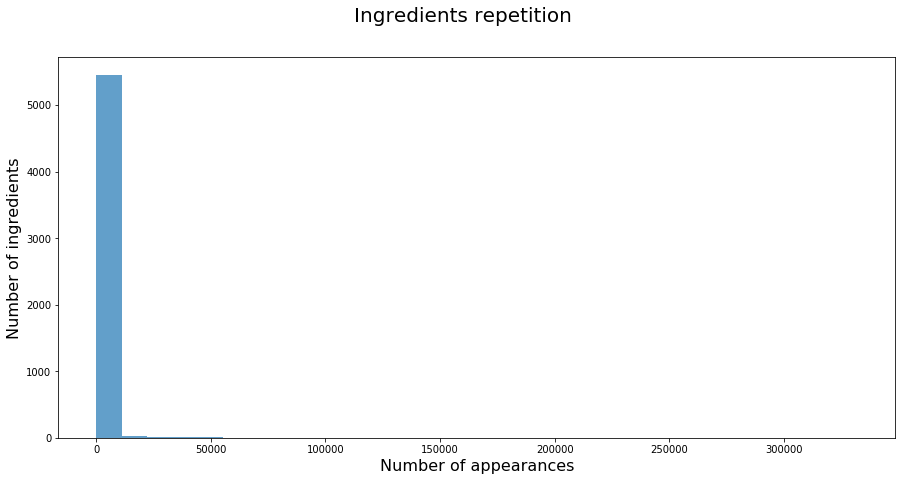

In [24]:
initial_time = time.time()
repetitionArray = []
mean = 0
for i in sorted_ingredients:
    repetitionArray.append(i[1])
    mean += i[1]
    
mean = mean/len(repetitionArray)
print(color.GREEN + "Number of total ingredients:", len(repetitionArray), color.END)
printMain("Average of appearances of the ingredients in recipes: " + str(round(mean, 2)) + " appearances.")
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle('Ingredients repetition', fontsize=20)
plt.xlabel('Number of appearances', fontsize=16)
plt.ylabel('Number of ingredients', fontsize=16)
ax.hist(repetitionArray,bins=30, alpha=0.7)
plt.show(fig)

In the above plot we can not really see how the distribution of ingredients appearances is, but we can know that the big mayority of ingredients (> 160000, nearly 100%) appear in a low ammount of recepies. 

Let's do the same analysis but with ingredients in more than 2000 appearances.

Ingredients in more than 2000 recipes:
Number of total ingredients: 261 
Average of appearances of the ingredients in recpies: 20511.25 appearances.


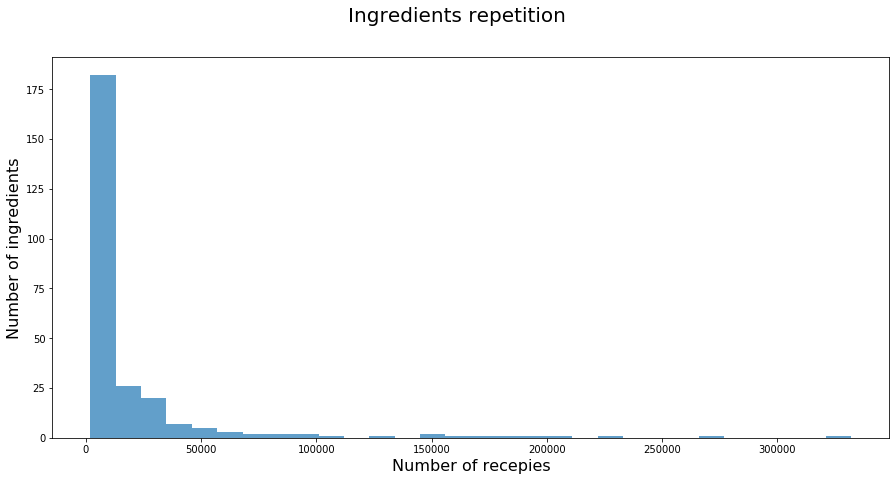

In [25]:
initial_time = time.time()
repetitionArray2 = []
mean2 = 0
for i in sorted_ingredients:
    if i[1] > 2000:
        mean += i[1]
        repetitionArray2.append(i[1])
        
mean = mean/len(repetitionArray2)
    
printMain("Ingredients in more than 2000 recipes:")
print(color.GREEN + "Number of total ingredients:", len(repetitionArray2), color.END)
printMain("Average of appearances of the ingredients in recpies: " + str(round(mean, 2)) + " appearances.")
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle('Ingredients repetition', fontsize=20)
plt.xlabel('Number of recepies', fontsize=16)
plt.ylabel('Number of ingredients', fontsize=16)
ax.hist(repetitionArray2, bins=30, alpha=0.7)
plt.show(fig)

Eventhough we have zoomed to avoid the ingredients repeated a few number of times, we still see that there are much more ingredients in the lower repetition part of the histogram. This shows us that we base our diet in a small ammount of ingredients, depending a lot on it. This lead us into the next question:

### Are there dominant ingredients?

The answer is yes, but let's see which ones are this, and how dominant they are they. For this, lets print a bar plot of the top 10 ingredients appearnace.

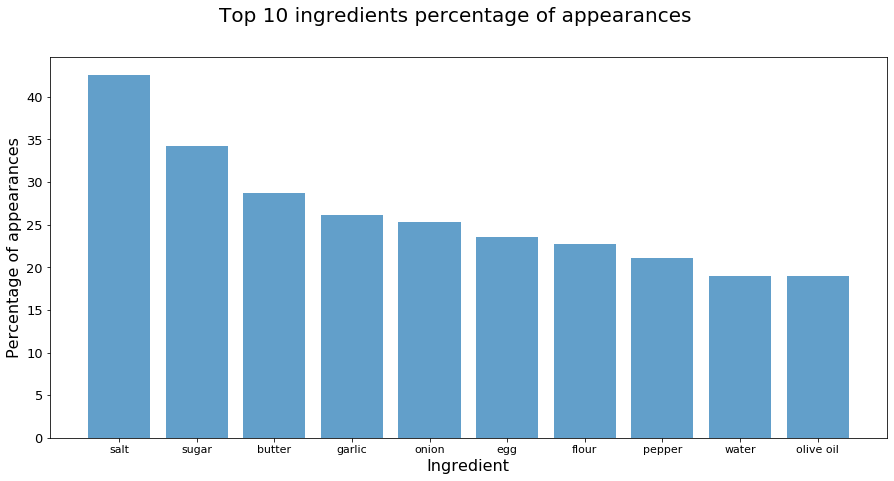

In [26]:
top10_ingredients = ingredients[:10]
top10_percentages = []

for i in repetitionArray2[:10]:
    top10_percentages.append(100*(i/len(df_ingredients)))
fig, ax = plt.subplots(figsize=(15, 7))
plt.bar(np.arange(len(top10_percentages)), top10_percentages,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=top10_ingredients) 
fig.suptitle('Top 10 ingredients percentage of appearances', fontsize=20)
plt.ylabel('Percentage of appearances', fontsize=16)
plt.xlabel('Ingredient', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

We can see that there are ingredients really dominant in our diet nowadays. `Salt` and `Sugar` is present in close to 50% of the recipes. To see this with more prespective, let's get the average precentage of appearances:

In [27]:
printMain("Average percentage of appearances of ingredients in recipes: " + str(round(100*mean/len(df_ingredients), 2)) + "%")

Average percentage of appearances of ingredients in recipes: 2.62%


Once again we can see that there is a huge dominance of the top ingredients in the way we eat, confirming to us that the decision made of concentraiting efford in the top 200 ingredients is, indeed, a good idea.

*Before the formating of the ingredients name with the aforementioned dictionary, the sugar was on the 3rd postion with a precentage of appearances of 30% (now is above 40%). This is just an example of why the forating was so important. In the case of the sugar, there were a lot of names for sugar, which is actually an important distinction for someone reading the recipe, but not for health, and, therefore, for us.*

### Are the most common ingredients healthy?

To answer this, let's get the unhealthy ingredients in the top 200 into a list and plot the top 10 (of the unhealthy) in a bar plot. 

In [28]:
df_unhealthy_ingredients = df_200_ingredients[df_200_ingredients["Unhealthy"] == 1]
unhealthy_ingredients = list(df_unhealthy_ingredients.index)
printMain("Top 10 unhealthy ingredients: ")
unhealthy_ingredients[:10]

Top 10 unhealthy ingredients: 


['sugar',
 'butter',
 'vegetable oil',
 'baking powder',
 'cream',
 'sour cream',
 'cream cheese',
 'cumin',
 'mayonnaise',
 'chocolate']

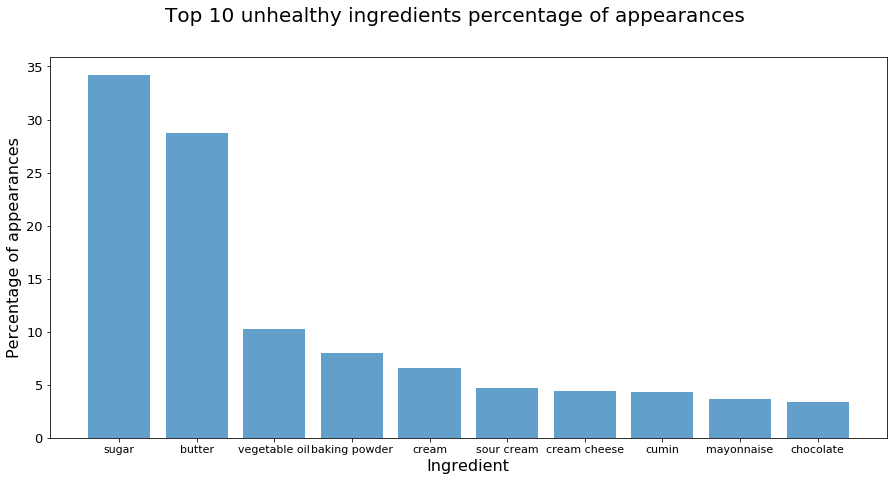

In [29]:
top10_percentages_unhealthy = []

for i in unhealthy_ingredients[:10]:
    top10_percentages_unhealthy.append(100*(dic_ingredients[i]/len(df_ingredients)))

fig, ax = plt.subplots(figsize=(15, 7))
plt.bar(np.arange(10), top10_percentages_unhealthy,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=unhealthy_ingredients[:10]) 
fig.suptitle('Top 10 unhealthy ingredients percentage of appearances', fontsize=20)
plt.ylabel('Percentage of appearances', fontsize=16)
plt.xlabel('Ingredient', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

We can see that there are some really dominant ingredients that are unhealthy (specially `sugar` and `butter`). This is going to make a lot of recepies unhealthy.

**Important note:** We understand that it is also important to the "healthiness" of a recipe the quantity of these "unhealthy" ingredients in the recepies. There are two reasons why we do not take this into account. Firstly, the way the quantities are defined in the dataset is impossible to automate the reading of the values, as they are directly extracted form the real recipes in web pages. Secondly, we belive we can still make the analysis we try to do as in the big mayority of recipes where unhealthy ingredients are used, they are used in an enough quantity to consider them as unhealthy. It is not common to use these unhealthy ingredients in such a low quantity that the meal created can be cataloged as healthy.

Let's finnaly see how this really affect the recipes. Let's catalog recipes as healthy or unhealthy, depending on if they contain or not unhealthy ingredients. Then, let's see what is the precentage of unhealthy recipes.

In [30]:
def isUnhealty(x):
    for i in x:
        if i in unhealthy_ingredients:
            return 1
    return 0
initial_time = time.time()
df_ingredients["Unhealthy"] = df_ingredients["ingredients"].apply(isUnhealty)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
df_ingredients.head()

(Time: 2.95 seconds)


,id,ingredients,Unhealthy
1,000033e39b,"[pasta, salt, bell pepper, pimentos, mayonnais...",1
2,000035f7ed,"[olive oil, cucumber, salt, tomatoes, bell pep...",0
3,00003a70b1,"[milk, french - fried onions, whole kernel cor...",1
5,0000631d90,"[beef, fresh garlic, cashew nuts, lemon, salt ...",1
6,000075604a,"[tea, pepper, chicken]",0


In [31]:
printMain("Number of unhealthy recepies: " + str(len(df_ingredients[df_ingredients["Unhealthy"] == 1])))
printMain("Number of healthy recepies: " + str(len(df_ingredients[df_ingredients["Unhealthy"] == 0])))
printMain("Percentage of unhealthy recipes: " + str(round(len(df_ingredients[df_ingredients["Unhealthy"] == 1])/len(df_ingredients),2)) + "%")

Number of unhealthy recepies: 552644
Number of healthy recepies: 229000
Percentage of unhealthy recipes: 0.71%


We can see then that only ~30% of the recipes are healthy. This lead us into the next question.

### Is it easier or harder to eat healthy with the selected diets?

Let's mark the recipes as being approved for the different diets.

In [39]:
# LactoseFree recipes
initial_time = time.time()
lactose_ingredients = df_200_ingredients[df_200_ingredients["Lactose"] == 0]
lactose_ingredients = list(lactose_ingredients.index)
def isLactolseFree(x):
    for i in x:
        if i in lactose_ingredients:
            return 0
    return 1
df_ingredients["LactoseFree"] = df_ingredients["ingredients"].apply(isLactolseFree)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of gluten free recepies: " + str(len(df_ingredients[df_ingredients["LactolseFree"] == 1])))

(Time: 2.01 seconds)
Number of gluten free recepies: 356344


In [33]:
# GlutenFree recipes
initial_time = time.time()
gluten_ingredients = df_200_ingredients[df_200_ingredients["Gluten"] == 0]
gluten_ingredients = list(gluten_ingredients.index)
def isGlutenFree(x):
    for i in x:
        if i in gluten_ingredients:
            return 0
    return 1
df_ingredients["GlutenFree"] = df_ingredients["ingredients"].apply(isGlutenFree)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of gluten free recepies: " + str(len(df_ingredients[df_ingredients["GlutenFree"] == 1])))

(Time: 2.06 seconds)
Number of gluten free recepies: 559626


In [34]:
# Vegan recipes
initial_time = time.time()
vegan_ingredients_blacklist = df_200_ingredients[df_200_ingredients["Vegan"] == 0                                           ]
vegan_ingredients_blacklist = list(vegan_ingredients_blacklist.index)
def isVegan(x):
    for i in x:
        if i in vegan_ingredients_blacklist:
            return 0
    return 1
df_ingredients["Vegan"] = df_ingredients["ingredients"].apply(isVegan)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of vegan recepies: " + str(len(df_ingredients[df_ingredients["Vegan"] == 1])))

(Time: 2.65 seconds)
Number of vegan recepies: 219984


Now, let's plot the precentage of healthy recipes per type of diet.

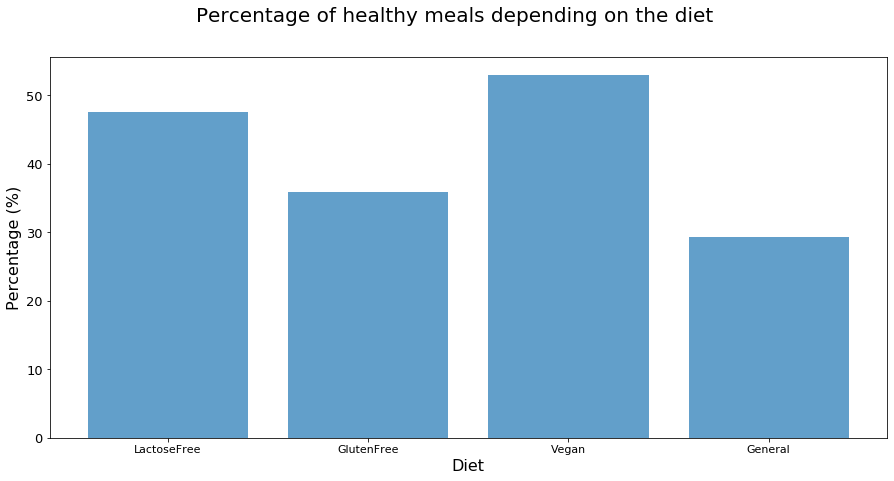

In [40]:
_data = []
_data.append(100*len(df_ingredients[(df_ingredients["LactoseFree"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["LactoseFree"] == 1]))
_data.append(100*len(df_ingredients[(df_ingredients["GlutenFree"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["GlutenFree"] == 1]))
_data.append(100*len(df_ingredients[(df_ingredients["Vegan"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["Vegan"] == 1]))
_data.append(100*len(df_ingredients[df_ingredients["Unhealthy"] == 0])/len(df_ingredients))
_keys = ["LactoseFree", "GlutenFree", "Vegan", "General"]
fig, ax = plt.subplots(figsize=(15, 7))
plt.bar(np.arange(4), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Percentage of healthy meals depending on the diet', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=16)
plt.xlabel('Diet', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

We can see that there are changes in the results. Apparently, for a vegan is easier to avoid unhealthy food than for a person with a regular diet. Abviously this is a simple approach, as we are not taking other things into account. However, it will help us a lot in the analysis for next milestone.

### What is the distribution of the number of ingredients of recepies?

Let's add a new feature to the dataFrame `df_ingredients`that has the length of the list of ingredients per recipe. Then, let's plot the distribution of values of this column.

In [41]:
initial_time = time.time()
df_ingredients['length'] = df_ingredients['ingredients'].apply(lambda x: len(x))
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("DataFrame with new column: ")
df_ingredients.head()

(Time: 0.39 seconds)
DataFrame with new column: 


,id,ingredients,Unhealthy,LactolseFree,GlutenFree,Vegan,length,LactoseFree
1,000033e39b,"[pasta, salt, bell pepper, pimentos, mayonnais...",1,0,0,0,9,0
2,000035f7ed,"[olive oil, cucumber, salt, tomatoes, bell pep...",0,1,1,1,8,1
3,00003a70b1,"[milk, french - fried onions, whole kernel cor...",1,0,1,0,7,0
5,0000631d90,"[beef, fresh garlic, cashew nuts, lemon, salt ...",1,1,1,0,10,1
6,000075604a,"[tea, pepper, chicken]",0,1,1,0,3,1


(Time: 0.05 seconds)


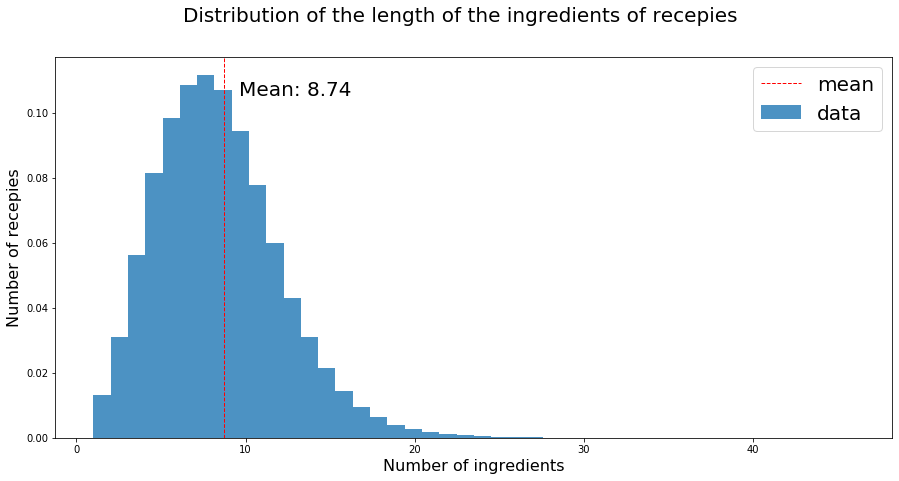

In [61]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients["length"]
_mean = df_ingredients["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of recepies', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of recepies', fontsize=16)
plt.hist(_data, density=True, bins=44, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
min_ylim, max_ylim = plt.ylim()
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

*In this analysis, we found out some outliers with large amount of ingredients (>100). We found out the problem was that some ingredients were repeated in the list. We actually solve this in the formating of ingredients prevouily done. It is done there 

### Does the distribution change when taking into account the diets?

Let's see.

(Time: 0.2 seconds)


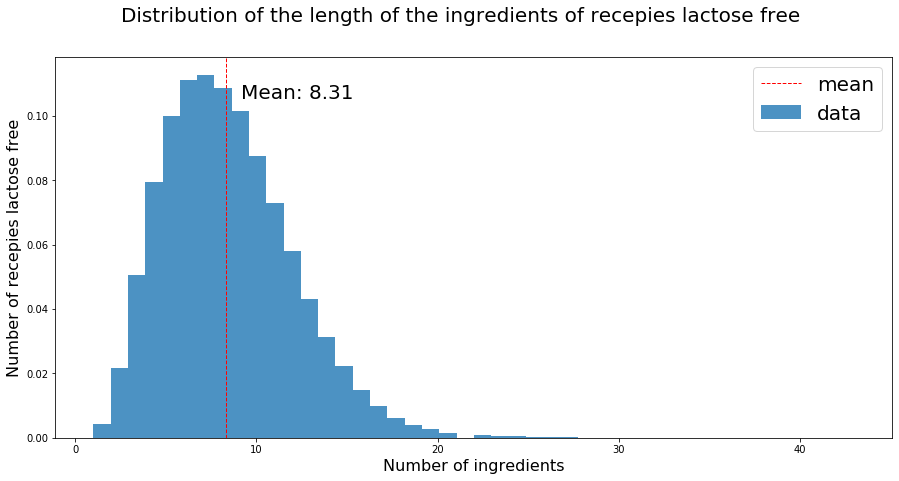

In [62]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["LactoseFree"] == 1]["length"]
_mean = df_ingredients[df_ingredients["LactoseFree"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of recepies lactose free', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of recepies lactose free', fontsize=16)
plt.hist(_data, density=True, bins=44, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

(Time: 0.21 seconds)


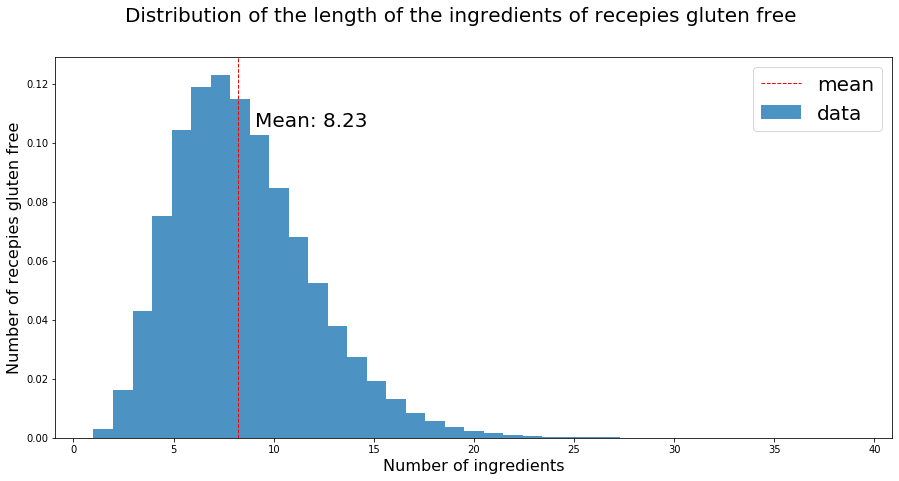

In [65]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["GlutenFree"] == 1]["length"]
_mean = df_ingredients[df_ingredients["GlutenFree"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of recepies gluten free', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of recepies gluten free', fontsize=16)
plt.hist(_data, density=True, bins=39, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

(Time: 0.14 seconds)


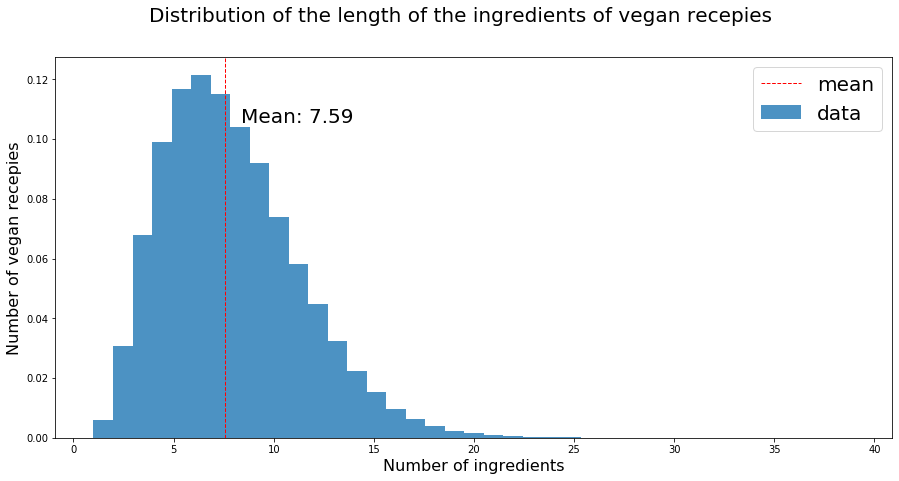

In [66]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["Vegan"] == 1]["length"]
_mean = df_ingredients[df_ingredients["Vegan"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of vegan recepies', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of vegan recepies', fontsize=16)
plt.hist(_data, density=True, bins=39, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

We see there are small changes in the distributions in the different diets, but they are not significant.

This general analysis has helped us detect some problems with the data (*Solved before in the notebook*) and also has given us important information that will be useful in the future analysis. There are more questions that are needed to be solved in the general analysis but are not for this milestone. They will be solved in future milestones.

## 4) Starting the core analysis

## 5) Conclusions and next steps